In [93]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import pyart
#from netCDF4 import Dataset

#dataset = Dataset('/home/hunzinger/data/rca_baseline_20181108.nc')
#n_baseline = dataset.variables['PDF counts'][:]
#bins_baseline = dataset.variables['PDF bins'][:]
#p_baseline = dataset.variables['CDF values'][:]
#dbz95_baseline = dataset.variables['Baseline 95th reflectivity'][:]
#dataset.close()

#print(dbz95_baseline)
#print(n_baseline)
#print(p_baseline)

In [94]:
def rca_create_baseline(filename, hPCT_on_50, vPCT_on_50, uhPCT_on_50, uvPCT_on_50, hmask, vmask, uhmask, uvmask):
    '''Calculates the 95th percentile clutter area reflectivity baseline using clutter map'''
    #radar = pyart.io.cfradial.read_cfradial(filename)
    radar = pyart.aux_io.read_gamic(filename, file_field_names=True)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    #r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 10000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    #zh = radar.fields['reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zh = radar.fields['Zh']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zv = radar.fields['Zv']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    uzh = radar.fields['UZh']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    uzv = radar.fields['UZv']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        zv = np.delete(zv,-diff,axis=0)
        uzh = np.delete(uzh,-diff,axis=0)
        uzv = np.delete(uzv,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx]
    zv = zv[sorted_idx]
    uzh = uzh[sorted_idx]
    uzv = uzv[sorted_idx]
    theta = theta[sorted_idx]
    
    # Create array to store qualifying reflectivities (fall within PCT_on > 0.5)
    #zh_car = np.empty((zh.shape))
    #zh_car[:,:] = np.nan
    #zv_car = np.empty((zv.shape))
    #zv_car[:,:] = np.nan
    #uzh_car = np.empty((uzh.shape))
    #uzh_car[:,:] = np.nan
    #uzv_car = np.empty((uzv.shape))
    #uzv_car[:,:] = np.nan
    
    # H POLARIZATION
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    #zh_car = zh[hmask]
    zh_car = zh[np.isfinite(hPCT_on_50)]
    #for i in range(0,len(hPCT_on_50[:,0])):
    #    for j in range(0,len(hPCT_on_50[0,:])):
    #        if np.isfinite(hPCT_on_50[i,j]):
    #            zh_car[i,j*10-10:j*10] = zh[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    #mask = np.where(np.isfinite(zh_car))  
    n,bins=np.histogram(zh_car,bins=525,range=(-40.,65.))
    #n,bins=np.histogram(zh_car[mask],bins=525,range=(-40.,65.))
    #n,bins,patches=plt.hist(zh_car[mask],bins=525,range=(-40.,65.))
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(n)
    p = cdf/cdf[-1]*100
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(p,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95 = poly_func(95.)
    
    # UZH POLARIZATION
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    #uzh_car = np.empty((uzh.shape))
    #uzh_car[:,:] = np.nan
    
    uzh_car = uzh[np.isfinite(uhPCT_on_50)]
    #uzh_car = uzh[uhmask]
    #for i in range(0,len(uhPCT_on_50[:,0])):
    #    for j in range(0,len(uhPCT_on_50[0,:])):
    #        if np.isfinite(uhPCT_on_50[i,j]):
    #            uzh_car[i,j*10-10:j*10] = uzh[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    #mask = np.where(np.isfinite(uzh_car))  
    #uhn,uhbins=np.histogram(uzh_car[mask],bins=525,range=(-40.,65.))
    uhn,uhbins=np.histogram(uzh_car,bins=525,range=(-40.,65.))
    #uhn,uhbins,uhpatches=plt.hist(uzh_car[mask],bins=525,range=(-40.,65.))
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(uhn)
    uhp = cdf/cdf[-1]*100
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(uhp,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95_uh = poly_func(95.)
    
    # V POLARIZATION
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    #zv_car = zv[vmask]
    zv_car = zv[np.isfinite(vPCT_on_50)]
    #for i in range(0,len(vPCT_on_50[:,0])):
    #    for j in range(0,len(vPCT_on_50[0,:])):
    #        if np.isfinite(vPCT_on_50[i,j]):
    #            zv_car[i,j*10-10:j*10] = zv[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    #mask = np.where(np.isfinite(zv_car))  
    vn,vbins=np.histogram(zv_car,bins=525,range=(-40.,65.))
    #vn,vbins=np.histogram(zv_car[mask],bins=525,range=(-40.,65.))
    #vn,vbins,vpatches=plt.hist(zv_car[mask],bins=525,range=(-40.,65.))
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(vn)
    vp = cdf/cdf[-1]*100
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(vp,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95_v = poly_func(95.)
    
    # UV POLARIZATION
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    #uzv_car = uzv[uvmask]
    uzv_car = uzv[np.isfinite(uvPCT_on_50)]
    #for i in range(0,len(uvPCT_on_50[:,0])):
    #    for j in range(0,len(uvPCT_on_50[0,:])):
    #        if np.isfinite(uvPCT_on_50[i,j]):
    #            uzv_car[i,j*10-10:j*10] = uzv[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    #mask = np.where(np.isfinite(uzv_car))  
    uvn,uvbins=np.histogram(uzv_car,bins=525,range=(-40.,65.))
    #uvn,uvbins=np.histogram(uzv_car[mask],bins=525,range=(-40.,65.))
    #uvn,uvbins,uvpatches=plt.hist(uzv_car[mask],bins=525,range=(-40.,65.))
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(uvn)
    uvp = cdf/cdf[-1]*100
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(uvp,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95_uv = poly_func(95.)
    
    del radar
    return date_time, n, bins, p, dbz95, vn, vbins, vp, dbz95_v, uhn, uhbins, uhp, dbz95_uh, uvn, uvbins, uvp, dbz95_uv


In [95]:
# Run this function on a bunch of files (try data from one day)
import os
import glob

from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_cluttermap_20181108.nc')
hPCT_on_50 = dataset.variables['clutter_gate_values_zh'][:,:]
vPCT_on_50 = dataset.variables['clutter_gate_values_zv'][:,:]
uhPCT_on_50 = dataset.variables['clutter_gate_values_uzh'][:,:]
uvPCT_on_50 = dataset.variables['clutter_gate_values_uzv'][:,:]
h_mask = dataset.variables['clutter_gate_mask_zh'][:,:]
v_mask = dataset.variables['clutter_gate_mask_zv'][:,:]
uh_mask = dataset.variables['clutter_gate_mask_uzh'][:,:]
uv_mask = dataset.variables['clutter_gate_mask_uzv'][:,:]
dataset.close()

dt = []
n = []
bins = []
p = []
dbz95 = []
vn = []
vbins = []
vp = []
dbz95_v = []
uhn = []
uhbins = []
uhp = []
dbz95_uh = []
uvn = []
uvbins = []
uvp = []
dbz95_uv = []

for f in glob.glob(os.path.join('/run/media/hunzinger/WININSTALL/csapr2-data/', 'corcsapr*.*cor-ppi*20181108*.h5')):
    print(f)
    DateTime, N, Bins, P, DBZ95, VN, VBins, VP, DBZ95V, UHN, UHBins, UHP, DBZ95UH, UVN, UVBins, UVP, DBZ95UV = rca_create_baseline(f, PCT_on_50, vPCT_on_50, uhPCT_on_50, uvPCT_on_50, h_mask, v_mask, uh_mask, uv_mask)
    
    # Put all PPI times into a list
    dt.append(DateTime)
    n.append(N)
    bins.append(Bins)
    p.append(P)
    dbz95.append(DBZ95)
    vn.append(VN)
    vbins.append(VBins)
    vp.append(VP)
    dbz95_v.append(DBZ95V)
    uhn.append(UHN)
    uhbins.append(UHBins)
    uhp.append(UHP)
    dbz95_uh.append(DBZ95UH)
    uvn.append(UVN)
    uvbins.append(UVBins)
    uvp.append(UVP)
    dbz95_uv.append(DBZ95UV)

/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.011001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108000003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108001503_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108003003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108004503_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108010003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.031001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108011503_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.031001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108013003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.031001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181

18.404938499119893
21.778154961229678
57.52864113984983 18.404938499119893
58.33197983479645 21.778154961229678
(360, 101)
(360, 101)


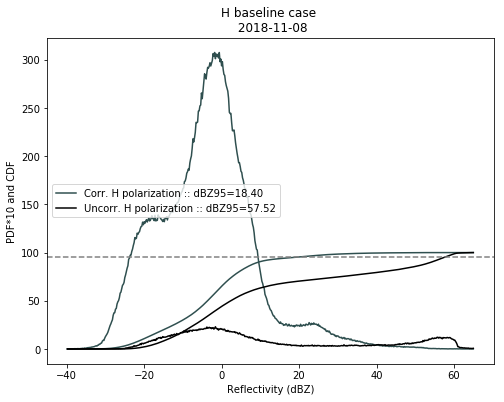

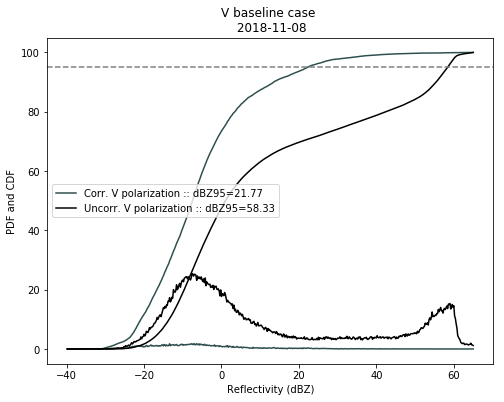

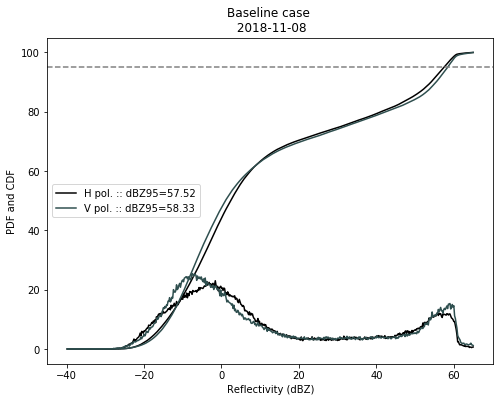

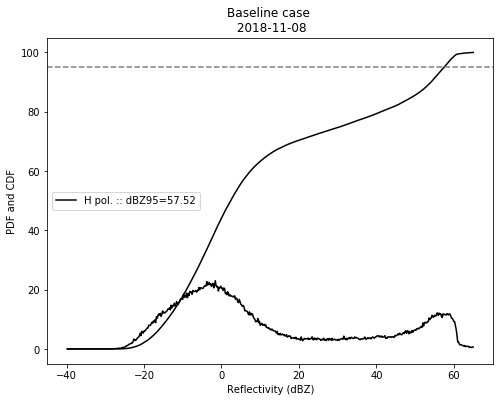

In [99]:
#dataset = Dataset('/home/hunzinger/data/rca_baseline_20181108.nc')
#n_baseline = dataset.variables['PDF counts'][:,:]
#bins_baseline = dataset.variables['PDF bins'][:,:]
#p_baseline = dataset.variables['CDF values'][:,:]
#dbz95_baseline = dataset.variables['Baseline 95th refletivity'][:]
#vn_baseline = dataset.variables['PDF counts (V)'][:,:]
#vbins_baseline = dataset.variables['PDF bins (V)'][:,:]
#vp_baseline = dataset.variables['CDF values (V)'][:,:]
#vdbz95_baseline = dataset.variables['Baseline 95th refletivity (V)'][:]
#dataset.close()

#dataset = Dataset('/home/hunzinger/data/rca_baseline_20181109.nc')
#n_baseline = dataset.variables['PDF counts'][:]
#bins_baseline = dataset.variables['PDF bins'][:]
#p_baseline = dataset.variables['CDF values'][:]
#dbz95_baseline = dataset.variables['Baseline 95th reflectivity'][:]
#dataset.close()

dbz95_baseline = np.nanmean(dbz95)
print(dbz95_baseline)
n = np.asarray(n)
bins = np.asarray(bins)
p = np.asarray(p)
n_baseline = np.nanmean(n,axis=0)
bins_baseline = bins[0,:]
p_baseline = np.nanmean(p,axis=0)

#plt.plot(bins_baseline[1:],n_baseline*10)
#plt.plot(bins_baseline[1:],p_baseline)
#plt.plot(x,p_baseline)
#plt.show()

vdbz95_baseline = np.nanmean(dbz95_v)
print(vdbz95_baseline)
vn = np.asarray(vn)
vbins = np.asarray(vbins)
vp = np.asarray(vp)
vn_baseline = np.nanmean(vn,axis=0)
vbins_baseline = vbins[0,:]
vp_baseline = np.nanmean(vp,axis=0)
#plt.plot(vbins_baseline[1:],vn_baseline*10)
#plt.plot(vbins_baseline[1:],vp_baseline)
#plt.show()
#plt.plot(x,p_baseline)

uhdbz95_baseline = np.nanmean(dbz95_uh)
print(uhdbz95_baseline, dbz95_baseline)
uhn = np.asarray(uhn)
uhbins = np.asarray(uhbins)
uhp = np.asarray(uhp)
uhn_baseline = np.nanmean(uhn,axis=0)
uhbins_baseline = uhbins[0,:]
uhp_baseline = np.nanmean(uhp,axis=0)

uvdbz95_baseline = np.nanmean(dbz95_uv)
print(uvdbz95_baseline, vdbz95_baseline)
uvn = np.asarray(uvn)
uvbins = np.asarray(uvbins)
uvp = np.asarray(uvp)
uvn_baseline = np.nanmean(uvn,axis=0)
uvbins_baseline = uvbins[0,:]
uvp_baseline = np.nanmean(uvp,axis=0)

# H and UZh
fig, ax1 = plt.subplots(figsize=[8,6])
ax1.plot(bins_baseline[1:],n_baseline,color='darkslategrey')#,linestyle='--')
ax1.plot(bins_baseline[1:],p_baseline,color='darkslategrey',label='Corr. H polarization :: dBZ95=18.40')
ax1.plot(uhbins_baseline[1:],uhn_baseline,color='k')
ax1.plot(uhbins_baseline[1:],uhp_baseline,color='k',label='Uncorr. H polarization :: dBZ95=57.52')
ax1.axhline(95.,color='grey',linestyle='--')

ax1.set_ylabel('PDF*10 and CDF')
ax1.set_xlabel('Reflectivity (dBZ)')
ax1.set_title('H baseline case \n 2018-11-08')
ax1.legend(loc='center left')

# V and UZv
fig, ax1 = plt.subplots(figsize=[8,6])
ax1.plot(vbins_baseline[1:],vn_baseline,color='darkslategrey')#,linestyle='--')
ax1.plot(vbins_baseline[1:],vp_baseline,color='darkslategrey',label='Corr. V polarization :: dBZ95=21.77')
ax1.plot(uvbins_baseline[1:],uvn_baseline,color='k')
ax1.plot(uvbins_baseline[1:],uvp_baseline,color='k',label='Uncorr. V polarization :: dBZ95=58.33')
ax1.axhline(95.,color='grey',linestyle='--')

ax1.set_ylabel('PDF and CDF')
ax1.set_xlabel('Reflectivity (dBZ)')
ax1.set_title('V baseline case \n 2018-11-08')
ax1.legend(loc='center left')

# UZh and UZv
fig, ax1 = plt.subplots(figsize=[8,6])
ax1.plot(uhbins_baseline[1:],uhn_baseline,color='k')
ax1.plot(uhbins_baseline[1:],uhp_baseline,color='k',label='H pol. :: dBZ95=57.52')
ax1.plot(uvbins_baseline[1:],uvn_baseline,color='darkslategrey')#,linestyle='--')
ax1.plot(uvbins_baseline[1:],uvp_baseline,color='darkslategrey',label='V pol. :: dBZ95=58.33')
ax1.axhline(95.,color='grey',linestyle='--')

ax1.set_ylabel('PDF and CDF')
ax1.set_xlabel('Reflectivity (dBZ)')
ax1.set_title('Baseline case \n 2018-11-08')
ax1.legend(loc='center left')

# UZh only
fig, ax1 = plt.subplots(figsize=[8,6])
ax1.plot(uhbins_baseline[1:],uhn_baseline,color='k')
ax1.plot(uhbins_baseline[1:],uhp_baseline,color='k',label='H pol. :: dBZ95=57.52')
ax1.axhline(95.,color='grey',linestyle='--')

ax1.set_ylabel('PDF and CDF')
ax1.set_xlabel('Reflectivity (dBZ)')
ax1.set_title('Baseline case \n 2018-11-08')
ax1.legend(loc='center left')

print(PCT_on_50.shape)
print(uhPCT_on_50.shape)

In [92]:
#d1 = Dataset('/home/hunzinger/data/rca_cluttermap_20181108.nc')
#PCT_on_50_1 = d1.variables['Flagged clutter grid gates'][:,:]
#d1.close()

d = Dataset('/home/hunzinger/data/rca_baseline_20181108.nc',
                  'w',format='NETCDF4_CLASSIC')

azi = d.createDimension('azi', 360)
rang = d.createDimension('rang', 11)
value = d.createDimension('value',1)
nbins = d.createDimension('nbins',525)
binsdim = d.createDimension('binsdim',526)
zrang = d.createDimension('zrang',101)

HPCT_ON_50 = d.createVariable('clutter_gate_values_zh', np.float64, ('azi','zrang'))
HDBZ95_BASE = d.createVariable('baseline_dbz95_zh', np.float64, ('value',))
HN_BASE = d.createVariable('pdf_counts_zh', np.float64, ('nbins',))
HBINS = d.createVariable('pdf_bins_zh', np.float64, ('binsdim',))
HP_BASE = d.createVariable('cdf_values_zh', np.float64, ('nbins',))
VPCT_ON_50 = d.createVariable('clutter_gate_values_zv', np.float64, ('azi','zrang'))
VDBZ95_BASE = d.createVariable('baseline_dbz95_zv', np.float64, ('value',))
VN_BASE = d.createVariable('pdf_counts_zv', np.float64, ('nbins',))
VBINS = d.createVariable('pdf_bins_zv', np.float64, ('binsdim',))
VP_BASE = d.createVariable('cdf_values_zv', np.float64, ('nbins',))
UHPCT_ON_50 = d.createVariable('clutter_gate_values_uzh', np.float64, ('azi','zrang'))
UHDBZ95_BASE = d.createVariable('baseline_dbz95_uzh', np.float64, ('value',))
UHN_BASE = d.createVariable('pdf_counts_uzh', np.float64, ('nbins',))
UHBINS = d.createVariable('pdf_bins_uzh', np.float64, ('binsdim',))
UHP_BASE = d.createVariable('cdf_values_uzh', np.float64, ('nbins',))
UVPCT_ON_50 = d.createVariable('clutter_gate_values_uzv', np.float64, ('azi','zrang'))
UVDBZ95_BASE = d.createVariable('baseline_dbz95_uzv', np.float64, ('value',))
UVN_BASE = d.createVariable('pdf_counts_uzv', np.float64, ('nbins',))
UVBINS = d.createVariable('pdf_bins_uzv', np.float64, ('binsdim',))
UVP_BASE = d.createVariable('cdf_values_uzv', np.float64, ('nbins',))
HMASK = d.createVariable('clutter_gate_mask_zh','i1',('azi','zrang'))
VMASK = d.createVariable('clutter_gate_mask_zv','i1',('azi','zrang'))
UHMASK = d.createVariable('clutter_gate_mask_uzh','i1',('azi','zrang'))
UVMASK = d.createVariable('clutter_gate_mask_uzv','i1',('azi','zrang'))

HPCT_ON_50.long_name = 'Flagged clutter grid gates (Zh)'
VPCT_ON_50.long_name = 'Flagged clutter grid gates (Zv)'
UHPCT_ON_50.long_name = 'Flagged clutter grid gates (UZh)'
UVPCT_ON_50.long_name = 'Flagged clutter grid gates (UZv)'
HDBZ95_BASE.long_name = 'Baseline 95th reflectivity (H)'
VDBZ95_BASE.long_name = 'Baseline 95th reflectivity (V)'
UHDBZ95_BASE.long_name = 'Baseline 95th reflectivity (UZh)'
UVDBZ95_BASE.long_name = 'Baseline 95th reflectivity (UZv)'
HN_BASE.long_name = 'PDF counts (H)'
VN_BASE.long_name = 'PDF counts (V)'
UHN_BASE.long_name = 'PDF counts (UZh)'
UVN_BASE.long_name = 'PDF counts (UZv)'
HBINS.long_name = 'PDF bins (H)'
VBINS.long_name = 'PDF bins (V)'
UHBINS.long_name = 'PDF bins (UZh)'
UVBINS.long_name = 'PDF bins (UZv)'
HP_BASE.long_name = 'CDF values (H)'
VP_BASE.long_name = 'CDF values (V)'
UHP_BASE.long_name = 'CDF values (UZh)'
UVP_BASE.long_name = 'CDF values (UZv)'
HMASK.long_name = 'Flagged clutter grid mask (H)'
VMASK.long_name = 'Flagged clutter grid mask (V)'
UHMASK.long_name = 'Flagged clutter grid mask (UZh)'
UVMASK.long_name = 'Flagged clutter grid mask (UZv)'

HPCT_ON_50[:,:] = hPCT_on_50
DBZ95_BASE[:] = dbz95_baseline
N_BASE[:] = n_baseline
BINS[:] = bins_baseline
P_BASE[:] = p_baseline
VPCT_ON_50[:,:] = vPCT_on_50
VDBZ95_BASE[:] = vdbz95_baseline
VN_BASE[:] = vn_baseline
VBINS[:] = vbins_baseline
VP_BASE[:] = vp_baseline
UHPCT_ON_50[:,:] = uhPCT_on_50
UHDBZ95_BASE[:] = uhdbz95_baseline
UHN_BASE[:] = uhn_baseline
UHBINS[:] = uhbins_baseline
UHP_BASE[:] = uhp_baseline
UVPCT_ON_50[:,:] = uvPCT_on_50
UVDBZ95_BASE[:] = uvdbz95_baseline
UVN_BASE[:] = uvn_baseline
UVBINS[:] = uvbins_baseline
UVP_BASE[:] = uvp_baseline
HMASK[:,:] = PCT_on_50
VMASK[:,:] = vPCT_on_50
UHMASK[:,:] = uhPCT_on_50
UVMASK[:,:] = uvPCT_on_50

d.close()